In [1]:
import pandas as pd
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_absolute_error
from imblearn.under_sampling import RandomUnderSampler

In [2]:
D = pd.read_csv("../assets/data/data_D.csv", header=None)
E = pd.read_csv("../assets/data/data_E.csv", header=None)

In [3]:
D.shape, E.shape

((2661, 24), (5274, 24))

<b>In chapter 1 we established that we can treat instances of ABC independent to DE since DE showed strong orthogonality wrt ABC</b>

In [4]:
def stat_summary(X, iqrl=0.25, iqrr=0.75):
    '''
    Return for each timestamp (hr) return min, max, 0.25 quantile, 0.75 quantile, mean, var
    '''
    return pd.DataFrame(np.array([np.min(X, axis=0), np.quantile(X, axis=0, q=iqrl), np.median(X, axis=0), 
          np.quantile(X, axis=0, q=iqrr), np.max(X, axis=0), np.mean(X, axis=0), np.var(X, axis=0), np.std(X, axis=0)]).transpose(),
                        columns=["Min", "0.25Q", "Med", "0.75Q", "Max", "Mean", "Var", "StD"])

def trend(X, span = None):
    '''
    Return EWMA trend for signal samples
    '''
    if not span:
        span = X.shape[1]
    return pd.DataFrame(X).apply(lambda x: x.ewm(span=span).mean(), axis=1)

def train_test_val_split(X, y=None, test_size=0.2,  val_size=0.4):
    from sklearn.model_selection import train_test_split
    if y and y.__len__() > 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=val_size)
        return X_train, X_test, X_val, y_train, y_test, y_val
    else:
        X_train, X_test = train_test_split(X, test_size=test_size)
        X_test, X_val = train_test_split(X_test, test_size=val_size)
        return X_train, X_test, X_val

def reshapeInput(X):
    X_ = []
    for x in X:
        X_.append(x.reshape(-1,1))
    return np.array(X_)

def shapeInput(X):
    X_ = []
    for x in X:
        X_.append(x.reshape(1,-1)[0])
    return np.array(X_)


def meanShift(X, window=None):
    '''
    Apply MA on convolved signal and compute rs means
    '''
    # At this point X must be EWMA convolved already
    if not window:
        window = X.shape[1] // 2
    return pd.DataFrame(X).apply(lambda x: x.rolling(window=window).mean(), axis=1).iloc[:,window-1:]

def gradient(X, shift=1, threshold=0):
    '''
    First order gradient of signal. Eq to diff for discrete signal
    '''
    return pd.DataFrame(X).apply(lambda x: x.diff(periods=shift), axis=1).iloc[:,threshold:]

def bucketPeaks(peakIndex):
    '''
    Bucket into first half and second half
    '''
    return(sum(peakIndex <= 12), sum(peakIndex > 12)) 

Lets take random samples and check

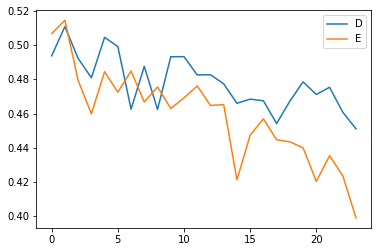

In [5]:
idx_1 = np.random.randint(0, min(D.__len__(), E.__len__()) // 1.2, 1)[0]
idx_2 = np.random.randint(idx_1, min(D.__len__(), E.__len__()), 1)[0]
plt.plot(stat_summary(D.values[idx_1:idx_2]).iloc[:,5], label="D")
plt.plot(stat_summary(E.values[idx_1:idx_2]).iloc[:,5], label="E")
plt.legend()
plt.show()

Lets work with a classifier to understand the confounding

In [6]:
from sklearn.ensemble import RandomForestClassifier
X = pd.concat([D,E], axis=0)
Y = [0]*D.__len__() + [1]*E.__len__()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, to_categorical(Y), test_size=0.25)

In [8]:
np.sum(y_train, axis=0)

array([1971., 3980.], dtype=float32)

In [9]:
from imblearn.under_sampling import RandomUnderSampler
X_train, y_train = RandomUnderSampler(random_state=42).fit_resample(X_train, y_train)

C:\Users\sabri\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [10]:
np.sum(to_categorical(y_train), axis=0)

array([1971., 1971.], dtype=float32)

In [11]:
rf = RandomForestClassifier().fit(X_train, y_train)

C:\Users\sabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [12]:
confusion_matrix(np.argmax(y_test, axis=1), rf.predict(X_test))

array([[445, 245],
       [538, 756]], dtype=int64)

In [13]:
print(classification_report(np.argmax(y_test, axis=1), rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.45      0.64      0.53       690
           1       0.76      0.58      0.66      1294

    accuracy                           0.61      1984
   macro avg       0.60      0.61      0.60      1984
weighted avg       0.65      0.61      0.61      1984



Some notes:<br/>
1. So the confoundance is both ways, given D many get predicted as E and vice versa
2. We might also have to remove C trends so that we can use one model for all classes

In [14]:
autoencoder_C = tf.keras.models.load_model("../assets/models/C_autoencoder_final")

In [15]:
mean_absolute_error(D.values, shapeInput(autoencoder_C.predict(reshapeInput(D.values))))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


0.2437479525489937

In [16]:
mean_absolute_error(E.values, shapeInput(autoencoder_C.predict(reshapeInput(E.values))))

0.24211761649020017

In [17]:
def clean(X, autoencoder_C, threshold_mae = 0.2):
    '''
    Uses recontruction errors (> threshold) to clean Tool A and Tool B signals
    '''
    #results = autoencoder_C.predict(reshapeInput(trend(X.values).values))
    results = autoencoder_C.predict(reshapeInput(X.values))
    #errors = mean_absolute_error(trend(X.values).values.transpose(), shapeInput(results).transpose(), multioutput='raw_values')
    errors = mean_absolute_error(X.values.transpose(), shapeInput(results).transpose(), multioutput='raw_values')
    return X.values[(errors > threshold_mae)]

def clean_self(X, autoencoder_C, threshold_mae = 0.2):
    '''
    Uses recontruction errors (> threshold) to clean Tool A and Tool B signals
    '''
    #results = autoencoder_C.predict(reshapeInput(trend(X.values).values))
    results = autoencoder_C.predict(reshapeInput(X.values))
    #errors = mean_absolute_error(trend(X.values).values.transpose(), shapeInput(results).transpose(), multioutput='raw_values')
    errors = mean_absolute_error(X.values.transpose(), shapeInput(results).transpose(), multioutput='raw_values')
    return X.values[(errors < threshold_mae)]

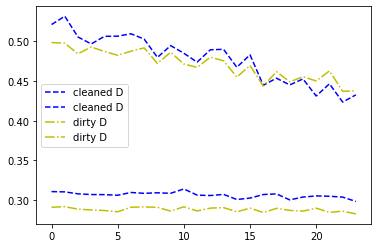

In [18]:
D_ = clean(D, autoencoder_C, 0.2437479525489937)
plt.plot(stat_summary(D_).iloc[:,[2,7]], 'b--',label='cleaned D')
plt.plot(stat_summary(D).iloc[:,[2,7]], 'y-.',label='dirty D')
plt.legend()
plt.show()

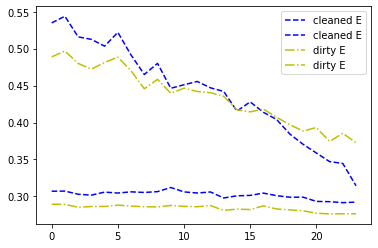

In [19]:
E_ = clean(E, autoencoder_C, 0.24211761649020017)
plt.plot(stat_summary(E_).iloc[:,[2,7]], 'b--',label='cleaned E')
plt.plot(stat_summary(E).iloc[:,[2,7]], 'y-.',label='dirty E')
plt.legend()
plt.show()

In [20]:
D_.__len__(), E.__len__()

(1323, 5274)

So we have made prominent the trend patterns and also add more variance information to distinguish these

Lets now try the model on the cleaned data

In [21]:
X = np.row_stack(([D_,E_]))
Y = [0]*D_.__len__() + [1]*E_.__len__()
X_train, X_test, y_train, y_test = train_test_split(X, to_categorical(Y), test_size=0.25)
X_train, y_train = RandomUnderSampler(random_state=42).fit_resample(X_train, y_train)
np.sum(to_categorical(y_train), axis=0)

C:\Users\sabri\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


array([1005., 1005.], dtype=float32)

In [22]:
rf = RandomForestClassifier().fit(X_train, y_train)
confusion_matrix(np.argmax(y_test, axis=1), rf.predict(X_test))

C:\Users\sabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


array([[184, 134],
       [266, 400]], dtype=int64)

In [23]:
print(classification_report(np.argmax(y_test, axis=1), rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.41      0.58      0.48       318
           1       0.75      0.60      0.67       666

    accuracy                           0.59       984
   macro avg       0.58      0.59      0.57       984
weighted avg       0.64      0.59      0.61       984



A unit of increase in accuracy, though not surprising since C was an anti pattern for D & E

Lets now go ahead with cleaning data D

In [24]:
timesteps = 24
input_dim = 1 
latent_dim = 1

inputs = tf.keras.Input(shape=(timesteps, input_dim))
encoded = tf.keras.layers.LSTM(latent_dim)(inputs)

decoded = tf.keras.layers.RepeatVector(timesteps)(encoded)
decoded = tf.keras.layers.LSTM(input_dim, return_sequences=True)(decoded)

sequence_autoencoder_D = tf.keras.Model(inputs, decoded)

In [25]:
X_train, X_test, X_val = train_test_val_split(D_, test_size=0.05)
# X_train, X_test, X_val = train_test_val_split(trend(C.values).values, test_size=0.1)

In [26]:
X_train.shape, X_val.shape

((1256, 24), (27, 24))

In [27]:
sequence_autoencoder_D.compile(loss="mae", metrics=[tf.keras.metrics.MeanSquaredError(name='mse')])
sequence_autoencoder_D.fit(reshapeInput(X_train), reshapeInput(X_train), batch_size=50, epochs=500, 
                         validation_data=(reshapeInput(X_val), reshapeInput(X_val)), 
                         callbacks=tf.keras.callbacks.EarlyStopping(patience=500, restore_best_weights=True))

Epoch 1/500
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
26/26 [==============================] - ETA: 0s - loss: 0.4000 - mse: 0.2440WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000002280F5FB0D8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and 

26/26 [==============================] - 0s 12ms/step - loss: 0.2721 - mse: 0.0954 - val_loss: 0.2735 - val_mse: 0.0956
Epoch 49/500
26/26 [==============================] - 0s 11ms/step - loss: 0.2724 - mse: 0.0956 - val_loss: 0.2735 - val_mse: 0.0957
Epoch 50/500
26/26 [==============================] - 0s 11ms/step - loss: 0.2709 - mse: 0.0947 - val_loss: 0.2734 - val_mse: 0.0956
Epoch 51/500
26/26 [==============================] - 0s 13ms/step - loss: 0.2723 - mse: 0.0955 - val_loss: 0.2734 - val_mse: 0.0956
Epoch 52/500
26/26 [==============================] - 0s 13ms/step - loss: 0.2722 - mse: 0.0953 - val_loss: 0.2734 - val_mse: 0.0955
Epoch 53/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2720 - mse: 0.0952 - val_loss: 0.2735 - val_mse: 0.0957
Epoch 54/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2709 - mse: 0.0947 - val_loss: 0.2735 - val_mse: 0.0956
Epoch 55/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2718 

26/26 [==============================] - 0s 11ms/step - loss: 0.2717 - mse: 0.0949 - val_loss: 0.2738 - val_mse: 0.0958
Epoch 110/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2713 - mse: 0.0946 - val_loss: 0.2737 - val_mse: 0.0958
Epoch 111/500
26/26 [==============================] - 0s 17ms/step - loss: 0.2710 - mse: 0.0943 - val_loss: 0.2738 - val_mse: 0.0959
Epoch 112/500
26/26 [==============================] - 0s 11ms/step - loss: 0.2708 - mse: 0.0943 - val_loss: 0.2739 - val_mse: 0.0959
Epoch 113/500
26/26 [==============================] - 0s 11ms/step - loss: 0.2717 - mse: 0.0947 - val_loss: 0.2739 - val_mse: 0.0959
Epoch 114/500
26/26 [==============================] - 0s 11ms/step - loss: 0.2712 - mse: 0.0946 - val_loss: 0.2739 - val_mse: 0.0959
Epoch 115/500
26/26 [==============================] - 0s 11ms/step - loss: 0.2707 - mse: 0.0942 - val_loss: 0.2739 - val_mse: 0.0959
Epoch 116/500
26/26 [==============================] - 0s 11ms/step - loss: 

26/26 [==============================] - 0s 12ms/step - loss: 0.2708 - mse: 0.0942 - val_loss: 0.2742 - val_mse: 0.0961
Epoch 171/500
26/26 [==============================] - 0s 11ms/step - loss: 0.2703 - mse: 0.0939 - val_loss: 0.2742 - val_mse: 0.0961
Epoch 172/500
26/26 [==============================] - 0s 11ms/step - loss: 0.2715 - mse: 0.0945 - val_loss: 0.2742 - val_mse: 0.0961
Epoch 173/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2715 - mse: 0.0946 - val_loss: 0.2742 - val_mse: 0.0961
Epoch 174/500
26/26 [==============================] - 0s 13ms/step - loss: 0.2711 - mse: 0.0942 - val_loss: 0.2742 - val_mse: 0.0961
Epoch 175/500
26/26 [==============================] - 0s 11ms/step - loss: 0.2710 - mse: 0.0942 - val_loss: 0.2742 - val_mse: 0.0961
Epoch 176/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2707 - mse: 0.0941 - val_loss: 0.2741 - val_mse: 0.0960
Epoch 177/500
26/26 [==============================] - 0s 13ms/step - loss: 

26/26 [==============================] - 0s 13ms/step - loss: 0.2708 - mse: 0.0942 - val_loss: 0.2744 - val_mse: 0.0962
Epoch 232/500
26/26 [==============================] - 0s 13ms/step - loss: 0.2710 - mse: 0.0942 - val_loss: 0.2744 - val_mse: 0.0963
Epoch 233/500
26/26 [==============================] - 0s 13ms/step - loss: 0.2706 - mse: 0.0940 - val_loss: 0.2745 - val_mse: 0.0963
Epoch 234/500
26/26 [==============================] - 0s 13ms/step - loss: 0.2712 - mse: 0.0945 - val_loss: 0.2744 - val_mse: 0.0962
Epoch 235/500
26/26 [==============================] - 0s 13ms/step - loss: 0.2704 - mse: 0.0939 - val_loss: 0.2744 - val_mse: 0.0962
Epoch 236/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2708 - mse: 0.0941 - val_loss: 0.2744 - val_mse: 0.0963
Epoch 237/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2704 - mse: 0.0940 - val_loss: 0.2745 - val_mse: 0.0963
Epoch 238/500
26/26 [==============================] - 0s 12ms/step - loss: 

26/26 [==============================] - 0s 12ms/step - loss: 0.2712 - mse: 0.0944 - val_loss: 0.2747 - val_mse: 0.0965
Epoch 293/500
26/26 [==============================] - 0s 11ms/step - loss: 0.2704 - mse: 0.0939 - val_loss: 0.2747 - val_mse: 0.0965
Epoch 294/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2714 - mse: 0.0943 - val_loss: 0.2747 - val_mse: 0.0965
Epoch 295/500
26/26 [==============================] - 0s 11ms/step - loss: 0.2707 - mse: 0.0938 - val_loss: 0.2747 - val_mse: 0.0965
Epoch 296/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2700 - mse: 0.0937 - val_loss: 0.2747 - val_mse: 0.0965
Epoch 297/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2708 - mse: 0.0940 - val_loss: 0.2746 - val_mse: 0.0964
Epoch 298/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2708 - mse: 0.0941 - val_loss: 0.2746 - val_mse: 0.0964
Epoch 299/500
26/26 [==============================] - 0s 11ms/step - loss: 

26/26 [==============================] - 0s 12ms/step - loss: 0.2696 - mse: 0.0935 - val_loss: 0.2749 - val_mse: 0.0966
Epoch 354/500
26/26 [==============================] - 0s 11ms/step - loss: 0.2706 - mse: 0.0940 - val_loss: 0.2749 - val_mse: 0.0966
Epoch 355/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2706 - mse: 0.0941 - val_loss: 0.2748 - val_mse: 0.0966
Epoch 356/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2713 - mse: 0.0944 - val_loss: 0.2749 - val_mse: 0.0966
Epoch 357/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2709 - mse: 0.0943 - val_loss: 0.2748 - val_mse: 0.0966
Epoch 358/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2710 - mse: 0.0944 - val_loss: 0.2748 - val_mse: 0.0966
Epoch 359/500
26/26 [==============================] - 0s 11ms/step - loss: 0.2696 - mse: 0.0935 - val_loss: 0.2748 - val_mse: 0.0966
Epoch 360/500
26/26 [==============================] - 0s 12ms/step - loss: 

26/26 [==============================] - 0s 12ms/step - loss: 0.2706 - mse: 0.0942 - val_loss: 0.2749 - val_mse: 0.0966
Epoch 415/500
26/26 [==============================] - 0s 14ms/step - loss: 0.2699 - mse: 0.0936 - val_loss: 0.2749 - val_mse: 0.0966
Epoch 416/500
26/26 [==============================] - 0s 14ms/step - loss: 0.2717 - mse: 0.0946 - val_loss: 0.2750 - val_mse: 0.0967
Epoch 417/500
26/26 [==============================] - 0s 14ms/step - loss: 0.2705 - mse: 0.0940 - val_loss: 0.2750 - val_mse: 0.0967
Epoch 418/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2712 - mse: 0.0943 - val_loss: 0.2750 - val_mse: 0.0967
Epoch 419/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2711 - mse: 0.0941 - val_loss: 0.2751 - val_mse: 0.0967
Epoch 420/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2708 - mse: 0.0942 - val_loss: 0.2750 - val_mse: 0.0967
Epoch 421/500
26/26 [==============================] - 0s 13ms/step - loss: 

26/26 [==============================] - 0s 12ms/step - loss: 0.2713 - mse: 0.0945 - val_loss: 0.2750 - val_mse: 0.0967
Epoch 476/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2705 - mse: 0.0941 - val_loss: 0.2750 - val_mse: 0.0967
Epoch 477/500
26/26 [==============================] - 0s 11ms/step - loss: 0.2711 - mse: 0.0944 - val_loss: 0.2750 - val_mse: 0.0967
Epoch 478/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2707 - mse: 0.0941 - val_loss: 0.2750 - val_mse: 0.0967
Epoch 479/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2711 - mse: 0.0942 - val_loss: 0.2750 - val_mse: 0.0967
Epoch 480/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2702 - mse: 0.0939 - val_loss: 0.2750 - val_mse: 0.0967
Epoch 481/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2713 - mse: 0.0946 - val_loss: 0.2751 - val_mse: 0.0967
Epoch 482/500
26/26 [==============================] - 0s 12ms/step - loss: 

In [28]:
mean_absolute_error(X_test, shapeInput(sequence_autoencoder_D.predict(reshapeInput(X_test))))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


0.26944884156965027

In [29]:
mean_absolute_error(E, shapeInput(sequence_autoencoder_D.predict(reshapeInput(E.values))))

0.24717023365537874

We might have to clean D itself first

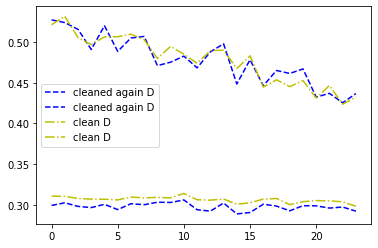

In [30]:
D__ = clean_self(pd.DataFrame(D_), sequence_autoencoder_D, 0.28)
plt.plot(stat_summary(D__).iloc[:,[2,7]], 'b--',label='cleaned again D')
plt.plot(stat_summary(D_).iloc[:,[2,7]], 'y-.',label='clean D')
plt.legend()
plt.show()

pd.DataFrame(D__).to_csv("../assets/data/D.csv")

sequence_autoencoder_D.save("../assets/models/D_autoencoder_dirty")

In [31]:
timesteps = 24
input_dim = 1 
latent_dim = 1

inputs = tf.keras.Input(shape=(timesteps, input_dim))
encoded = tf.keras.layers.LSTM(latent_dim)(inputs)

decoded = tf.keras.layers.RepeatVector(timesteps)(encoded)
decoded = tf.keras.layers.LSTM(input_dim, return_sequences=True)(decoded)

sequence_autoencoder_D = tf.keras.Model(inputs, decoded)

In [32]:
X_train, X_test, X_val = train_test_val_split(D__, test_size=0.05)

In [33]:
X_train.shape, X_val.shape

((906, 24), (20, 24))

In [34]:
sequence_autoencoder_D.compile(loss="mae", metrics=[tf.keras.metrics.MeanSquaredError(name='mse')])
sequence_autoencoder_D.fit(reshapeInput(X_train), reshapeInput(X_train), batch_size=50, epochs=500, 
                         validation_data=(reshapeInput(X_val), reshapeInput(X_val)), 
                         callbacks=tf.keras.callbacks.EarlyStopping(patience=500, restore_best_weights=True))

Epoch 1/500
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/19 [=========================>....] - ETA: 0s - loss: 0.5695 - mse: 0.4172WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000022618F8F438> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and 

19/19 [==============================] - 0s 14ms/step - loss: 0.2625 - mse: 0.0903 - val_loss: 0.2658 - val_mse: 0.0927
Epoch 49/500
19/19 [==============================] - 0s 13ms/step - loss: 0.2624 - mse: 0.0902 - val_loss: 0.2658 - val_mse: 0.0926
Epoch 50/500
19/19 [==============================] - 0s 13ms/step - loss: 0.2629 - mse: 0.0905 - val_loss: 0.2657 - val_mse: 0.0925
Epoch 51/500
19/19 [==============================] - 0s 15ms/step - loss: 0.2620 - mse: 0.0902 - val_loss: 0.2657 - val_mse: 0.0925
Epoch 52/500
19/19 [==============================] - 0s 14ms/step - loss: 0.2619 - mse: 0.0900 - val_loss: 0.2656 - val_mse: 0.0924
Epoch 53/500
19/19 [==============================] - 0s 14ms/step - loss: 0.2625 - mse: 0.0903 - val_loss: 0.2656 - val_mse: 0.0923
Epoch 54/500
19/19 [==============================] - 0s 13ms/step - loss: 0.2624 - mse: 0.0903 - val_loss: 0.2655 - val_mse: 0.0923
Epoch 55/500
19/19 [==============================] - 0s 13ms/step - loss: 0.2622 

19/19 [==============================] - 0s 15ms/step - loss: 0.2615 - mse: 0.0893 - val_loss: 0.2639 - val_mse: 0.0907
Epoch 110/500
19/19 [==============================] - 0s 15ms/step - loss: 0.2611 - mse: 0.0891 - val_loss: 0.2639 - val_mse: 0.0907
Epoch 111/500
19/19 [==============================] - 0s 12ms/step - loss: 0.2610 - mse: 0.0890 - val_loss: 0.2639 - val_mse: 0.0906
Epoch 112/500
19/19 [==============================] - 0s 13ms/step - loss: 0.2610 - mse: 0.0890 - val_loss: 0.2639 - val_mse: 0.0906
Epoch 113/500
19/19 [==============================] - 0s 15ms/step - loss: 0.2612 - mse: 0.0890 - val_loss: 0.2639 - val_mse: 0.0906
Epoch 114/500
19/19 [==============================] - 0s 14ms/step - loss: 0.2615 - mse: 0.0894 - val_loss: 0.2639 - val_mse: 0.0906
Epoch 115/500
19/19 [==============================] - 0s 13ms/step - loss: 0.2614 - mse: 0.0893 - val_loss: 0.2639 - val_mse: 0.0906
Epoch 116/500
19/19 [==============================] - 0s 12ms/step - loss: 

19/19 [==============================] - 0s 13ms/step - loss: 0.2606 - mse: 0.0887 - val_loss: 0.2632 - val_mse: 0.0902
Epoch 171/500
19/19 [==============================] - 0s 12ms/step - loss: 0.2606 - mse: 0.0887 - val_loss: 0.2632 - val_mse: 0.0902
Epoch 172/500
19/19 [==============================] - 0s 13ms/step - loss: 0.2607 - mse: 0.0887 - val_loss: 0.2632 - val_mse: 0.0901
Epoch 173/500
19/19 [==============================] - 0s 13ms/step - loss: 0.2604 - mse: 0.0887 - val_loss: 0.2632 - val_mse: 0.0901
Epoch 174/500
19/19 [==============================] - 0s 13ms/step - loss: 0.2614 - mse: 0.0892 - val_loss: 0.2632 - val_mse: 0.0901
Epoch 175/500
19/19 [==============================] - 0s 12ms/step - loss: 0.2608 - mse: 0.0889 - val_loss: 0.2632 - val_mse: 0.0901
Epoch 176/500
19/19 [==============================] - 0s 13ms/step - loss: 0.2614 - mse: 0.0892 - val_loss: 0.2632 - val_mse: 0.0901
Epoch 177/500
19/19 [==============================] - 0s 13ms/step - loss: 

19/19 [==============================] - 0s 13ms/step - loss: 0.2607 - mse: 0.0889 - val_loss: 0.2630 - val_mse: 0.0900
Epoch 232/500
19/19 [==============================] - 0s 14ms/step - loss: 0.2611 - mse: 0.0890 - val_loss: 0.2630 - val_mse: 0.0900
Epoch 233/500
19/19 [==============================] - 0s 13ms/step - loss: 0.2610 - mse: 0.0890 - val_loss: 0.2630 - val_mse: 0.0900
Epoch 234/500
19/19 [==============================] - 0s 13ms/step - loss: 0.2608 - mse: 0.0888 - val_loss: 0.2630 - val_mse: 0.0900
Epoch 235/500
19/19 [==============================] - 0s 13ms/step - loss: 0.2614 - mse: 0.0892 - val_loss: 0.2630 - val_mse: 0.0900
Epoch 236/500
19/19 [==============================] - 0s 13ms/step - loss: 0.2612 - mse: 0.0889 - val_loss: 0.2629 - val_mse: 0.0900
Epoch 237/500
19/19 [==============================] - 0s 13ms/step - loss: 0.2610 - mse: 0.0890 - val_loss: 0.2629 - val_mse: 0.0900
Epoch 238/500
19/19 [==============================] - 0s 13ms/step - loss: 

19/19 [==============================] - 0s 17ms/step - loss: 0.2610 - mse: 0.0890 - val_loss: 0.2629 - val_mse: 0.0899
Epoch 293/500
19/19 [==============================] - 0s 15ms/step - loss: 0.2607 - mse: 0.0888 - val_loss: 0.2629 - val_mse: 0.0899
Epoch 294/500
19/19 [==============================] - 0s 14ms/step - loss: 0.2601 - mse: 0.0885 - val_loss: 0.2629 - val_mse: 0.0899
Epoch 295/500
19/19 [==============================] - 0s 15ms/step - loss: 0.2604 - mse: 0.0886 - val_loss: 0.2629 - val_mse: 0.0899
Epoch 296/500
19/19 [==============================] - 0s 15ms/step - loss: 0.2611 - mse: 0.0890 - val_loss: 0.2628 - val_mse: 0.0899
Epoch 297/500
19/19 [==============================] - 0s 15ms/step - loss: 0.2609 - mse: 0.0891 - val_loss: 0.2628 - val_mse: 0.0899
Epoch 298/500
19/19 [==============================] - 0s 12ms/step - loss: 0.2610 - mse: 0.0887 - val_loss: 0.2628 - val_mse: 0.0899
Epoch 299/500
19/19 [==============================] - 0s 13ms/step - loss: 

Epoch 353/500
19/19 [==============================] - 0s 13ms/step - loss: 0.2610 - mse: 0.0890 - val_loss: 0.2628 - val_mse: 0.0899
Epoch 354/500
19/19 [==============================] - 0s 12ms/step - loss: 0.2604 - mse: 0.0886 - val_loss: 0.2628 - val_mse: 0.0899
Epoch 355/500
19/19 [==============================] - 0s 14ms/step - loss: 0.2609 - mse: 0.0890 - val_loss: 0.2628 - val_mse: 0.0899
Epoch 356/500
19/19 [==============================] - 0s 14ms/step - loss: 0.2606 - mse: 0.0889 - val_loss: 0.2628 - val_mse: 0.0899
Epoch 357/500
19/19 [==============================] - 0s 13ms/step - loss: 0.2610 - mse: 0.0890 - val_loss: 0.2628 - val_mse: 0.0899
Epoch 358/500
19/19 [==============================] - 0s 12ms/step - loss: 0.2611 - mse: 0.0891 - val_loss: 0.2628 - val_mse: 0.0899
Epoch 359/500
19/19 [==============================] - 0s 12ms/step - loss: 0.2602 - mse: 0.0886 - val_loss: 0.2628 - val_mse: 0.0899
Epoch 360/500
19/19 [==============================] - 0s 12ms

19/19 [==============================] - 0s 15ms/step - loss: 0.2605 - mse: 0.0886 - val_loss: 0.2628 - val_mse: 0.0898
Epoch 415/500
19/19 [==============================] - 0s 13ms/step - loss: 0.2605 - mse: 0.0886 - val_loss: 0.2628 - val_mse: 0.0898
Epoch 416/500
19/19 [==============================] - 0s 13ms/step - loss: 0.2608 - mse: 0.0890 - val_loss: 0.2628 - val_mse: 0.0898
Epoch 417/500
19/19 [==============================] - 0s 12ms/step - loss: 0.2606 - mse: 0.0885 - val_loss: 0.2628 - val_mse: 0.0899
Epoch 418/500
19/19 [==============================] - 0s 12ms/step - loss: 0.2610 - mse: 0.0889 - val_loss: 0.2628 - val_mse: 0.0899
Epoch 419/500
19/19 [==============================] - 0s 14ms/step - loss: 0.2608 - mse: 0.0890 - val_loss: 0.2628 - val_mse: 0.0898
Epoch 420/500
19/19 [==============================] - 0s 13ms/step - loss: 0.2607 - mse: 0.0889 - val_loss: 0.2628 - val_mse: 0.0898
Epoch 421/500
19/19 [==============================] - 0s 12ms/step - loss: 

19/19 [==============================] - 0s 13ms/step - loss: 0.2613 - mse: 0.0894 - val_loss: 0.2628 - val_mse: 0.0898
Epoch 476/500
19/19 [==============================] - 0s 12ms/step - loss: 0.2608 - mse: 0.0889 - val_loss: 0.2628 - val_mse: 0.0898
Epoch 477/500
19/19 [==============================] - 0s 12ms/step - loss: 0.2607 - mse: 0.0889 - val_loss: 0.2628 - val_mse: 0.0898
Epoch 478/500
19/19 [==============================] - 0s 13ms/step - loss: 0.2609 - mse: 0.0889 - val_loss: 0.2628 - val_mse: 0.0898
Epoch 479/500
19/19 [==============================] - 0s 12ms/step - loss: 0.2607 - mse: 0.0888 - val_loss: 0.2628 - val_mse: 0.0898
Epoch 480/500
19/19 [==============================] - 0s 13ms/step - loss: 0.2605 - mse: 0.0887 - val_loss: 0.2628 - val_mse: 0.0898
Epoch 481/500
19/19 [==============================] - 0s 12ms/step - loss: 0.2608 - mse: 0.0887 - val_loss: 0.2628 - val_mse: 0.0898
Epoch 482/500
19/19 [==============================] - 0s 12ms/step - loss: 

In [35]:
mean_absolute_error(X_test, shapeInput(sequence_autoencoder_D.predict(reshapeInput(X_test))))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


0.2627238611836947

In [36]:
mean_absolute_error(E, shapeInput(sequence_autoencoder_D.predict(reshapeInput(E.values))))

0.246957794876953

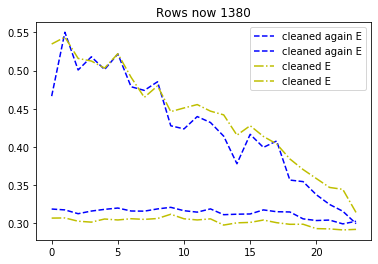

In [39]:
E__ = clean(pd.DataFrame(E_), sequence_autoencoder_D, 0.265)
plt.plot(stat_summary(E__).iloc[:,[2,7]], 'b--',label='cleaned again E')
plt.plot(stat_summary(E_).iloc[:,[2,7]], 'y-.',label='cleaned E')
plt.legend()
plt.title(f"Rows now {E__.__len__()}")
plt.show()

pd.DataFrame(E__).to_csv("../assets/data/cleaned/E.csv")

sequence_autoencoder_D.save("../assets/models/D_autoencoder_clean")